In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import mstats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pystan
import arviz

In [2]:
data = pd.read_csv("./input/data7.csv")
data = pd.get_dummies(data)
data.head(10)

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5
5,8,0,2,6
6,8,0,2,7
7,8,7,2,8
8,8,1,2,9
9,8,6,2,10


 タスクとしては
 植物１００個からそれぞれ８個の種子を取得したとき、生存している種子数yiを予測する

 N: それぞれの植物から取得した種子の数 すべての植物から8個ずつ取っている
 y: 生存種子数(0≦y≦N)
 x: それぞれの植物の葉の数
 y(生存種子数)は、8Cy*qi*(1-qi)^(8-N) の二項分布に従うと仮定する
 logit(qi) = beta_0 + beta_1*xi + ri の線形予測子+リンク関数ですことにする
 ここでriは個体差を表し、 ri = Norm(0, s)で表される正規分布で表される

 今回は beta_0, beta_1, s をMCMCを使って求める

In [3]:
stan_model="""
data {
    int N;    // データ数
    int X[N]; // それぞれの植物の葉の数
    int Y[N]; // それぞれの植物の生存種子数
}

parameters {
    real beta_0; // intercept
    real beta_1; // 葉の数の係数
    real s;      // 個体差項の標準偏差

    real r[N];
       // 各種子の生存確率 確率なので 0≦p≦1 
}

transformed parameters {
    real<lower=0, upper=1> p[N];
    for (n in 1:N) {
        p[n] = inv_logit(beta_0 + beta_1*X[n]+r[n]);
    }
}

model {
    for (n in 1:N) {
        r[n] ~ normal(0.0, s);
    }
    Y ~ binomial(8, p); // 二項分布に従う
}
"""

In [4]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a8bcc00d25fd2a7ef5609829fc61d082 NOW.


In [5]:
stan_data = {
    "N": data.shape[0],
    "X": data["x"],
    "Y": data["y"]
}

fit = sm.sampling(data=stan_data, iter=5000, warmup=1000, chains=3, seed=0)
print(fit)

Inference for Stan model: anon_model_a8bcc00d25fd2a7ef5609829fc61d082.
3 chains, each with iter=5000; warmup=1000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=12000.

         mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
beta_0   -4.3    0.02   0.98  -6.36  -4.92   -4.26  -3.62  -2.49   2456    1.0
beta_1   1.03  4.7e-3   0.23    0.6   0.87    1.02   1.18   1.51   2426    1.0
s        2.65  6.3e-3   0.34   2.06   2.41    2.62   2.86   3.41   3001    1.0
r[1]    -2.08    0.01   1.82  -6.17   -3.2   -1.88  -0.79   0.94  15443    1.0
r[2]    -0.08    0.01    1.2  -2.69   -0.8  6.6e-3   0.74   2.07   9035    1.0
r[3]     0.87    0.01   0.99  -1.16   0.23     0.9   1.53   2.75   6654    1.0
r[4]     2.06    0.01   0.91   0.29   1.45    2.06   2.66   3.88   5488    1.0
r[5]    -0.07    0.01    1.2  -2.66  -0.81    0.01   0.75   2.04   8727    1.0
r[6]    -2.07    0.01   1.82  -6.22  -3.16   -1.87  -0.79   0.97  14836    1.0
r[7]    -2.07    0.0

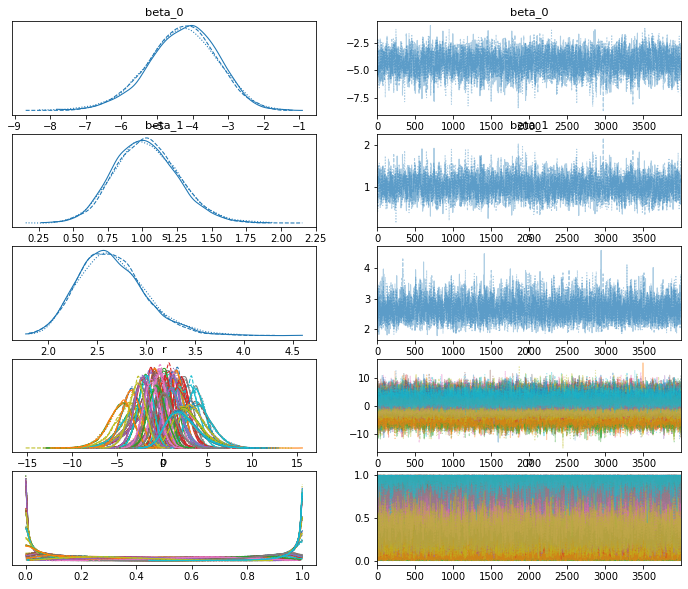

In [6]:
fig = arviz.plot_trace(fit)